In [187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
# from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

from itertools import product
import statsmodels.api as sm

from tensorflow.keras.layers import Dense, Activation, Dropout, LSTM  # Updated import paths
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
import tensorflow as tf

from itertools import cycle
import scipy.stats as stats
import seaborn as sns

plt.style.use('seaborn-darkgrid')
import warnings
warnings.filterwarnings("ignore")

In [188]:
df = pd.read_csv('../data/returns_svi_edgar.csv')
df = df[['symbol', 'date', 'svi.1', 'edgar', 'price', 'volume', 'WeeklyReturns']]
df.rename(columns = {'svi.1':'svi'}, inplace=True)
df.head()

,symbol,date,svi,edgar,price,volume,WeeklyReturns
0,MSFT,2005-01-02,31338,145,26.67,398924026.0,NaN
1,MSFT,2005-01-09,33079,3220,26.12,379712121.0,-2.062242
2,MSFT,2005-01-16,20892,3030,25.65,266617523.0,-1.799387
3,MSFT,2005-01-23,34820,3539,26.18,409844550.0,2.066277
4,MSFT,2005-01-30,26115,4112,26.32,347830186.0,0.534759


In [189]:
df['returns'] = df['WeeklyReturns'].apply(lambda x: np.round(x, 0))


In [190]:
df_na = pd.DataFrame(columns = ['symbol','total'])
for s in df['symbol'].unique():
     NAs = df.loc[df['symbol'] == s]['price'].isna().sum()
     df_na.loc[len(df_na)] = {'symbol':s, 'total':NAs}

df_na


,symbol,total
0,MSFT,0
1,AAPL,0
2,NVDA,0
3,AMZN,0
4,GOOG,0
...,...,...
387,PYPL,550
388,VLO,0
389,BA.L,962
390,HUM,0


In [191]:
na_symbols = df_na.loc[df_na['total'] > 0]['symbol'].to_list()

In [192]:
# symbols with na data
for s in na_symbols:
     df = df.loc[df['symbol'] != s]

print(len(df))
print(df['symbol'].nunique())

287638
299


In [193]:
# some prices are zero
minus_symbols = df.loc[df['price']<0]['symbol'].unique()
for s in minus_symbols:
     df = df.loc[df['symbol'] != s]

print(len(df))
print(df['symbol'].nunique())

278980
290


In [194]:
df['WeeklyReturns'] = 0.0  # Initialize the column with zeros

for company in df['symbol'].unique():
    company_mask = df['symbol'] == company
    df.loc[company_mask, 'WeeklyReturns'] = df.loc[company_mask, 'price'].pct_change() * 100

In [195]:
df.reset_index(inplace=True)
df['returns'] = df['WeeklyReturns'].apply(lambda x: np.round(x, 0))

In [45]:
df.to_csv("../data/new_dataset.csv")

In [148]:
df = pd.read_csv("../data/new_dataset.csv")
df['date'] = pd.to_datetime(df['date'])

In [149]:
cap_df = pd.read_csv('../data/companies_after_2005.csv')
cap_df.rename(columns={'Symbol':'symbol'}, inplace=True)
df_total = pd.merge(df, cap_df[['symbol', 'capitalization']], on='symbol', how='left')
df_total.head(2)

,Unnamed: 0,index,symbol,date,svi,edgar,price,volume,WeeklyReturns,returns,capitalization
0,0,0,MSFT,2005-01-02,31338,145,26.67,398924026.0,NaN,NaN,high
1,1,1,MSFT,2005-01-09,33079,3220,26.12,379712121.0,-2.062242,-2.0,high


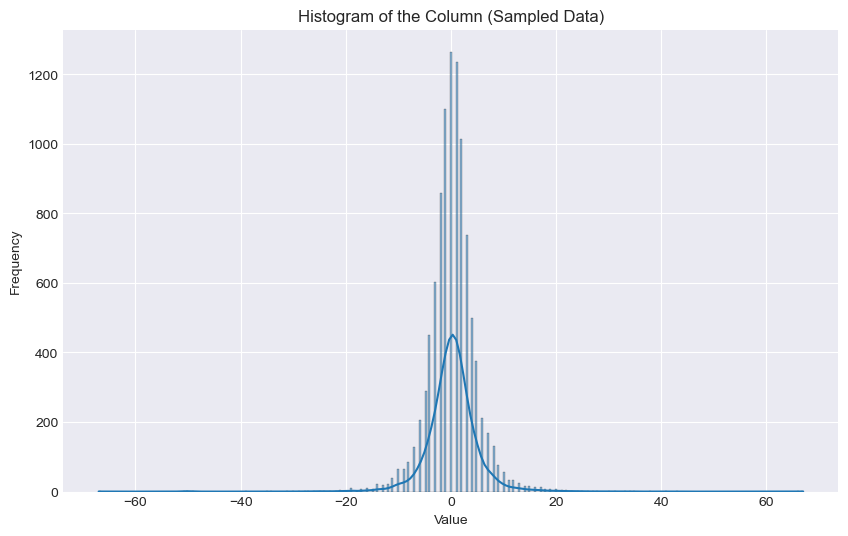

In [145]:

column_data = df['returns']

# Sample a subset of your data
sample_size = min(10000, len(column_data))  # Adjust sample size as desired
column_sample = column_data.sample(n=sample_size, random_state=1)

# Plotting the histogram with the sampled data
plt.figure(figsize=(10, 6))
sns.histplot(column_sample, kde=True)
plt.title('Histogram of the Column (Sampled Data)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()


In [146]:
df.loc[(df['returns']>20) | (df['returns']<-20)]

,Unnamed: 0,index,symbol,date,svi,edgar,price,volume,WeeklyReturns,returns
970,970,970,AAPL,2005-02-27,44120,1521,42.81,1.343104e+08,-51.893471,-52.0
1157,1157,1157,AAPL,2008-09-28,147802,4371,97.07,3.377796e+08,-24.305995,-24.0
1454,1454,1454,AAPL,2014-06-08,145264,89222,91.28,2.931859e+08,-85.860558,-86.0
1779,1779,1779,AAPL,2020-08-30,170600,7538,120.96,1.166973e+09,-75.770687,-76.0
1989,1989,1989,NVDA,2006-04-02,18212,0,30.53,4.539995e+07,-46.681802,-47.0
...,...,...,...,...,...,...,...,...,...,...
278739,278739,376602,HES,2008-10-26,31500,511,60.21,3.099170e+07,20.564678,21.0
278744,278744,376607,HES,2008-11-30,28875,1802,38.49,3.006420e+07,-28.774981,-29.0
278745,278745,376608,HES,2008-12-07,33250,775,47.70,3.019850e+07,23.928293,24.0
278811,278811,376935,STM,2020-03-15,122721,0,16.42,2.073260e+07,-23.019222,-23.0


In [50]:
# Getting specific quartiles
Q1 = column_data.quantile(0.25)
Q2 = column_data.quantile(0.5)  # Median
Q3 = column_data.quantile(0.75)

print(f"1st Quartile (Q1): {Q1}")
print(f"Median (Q2): {Q2}")
print(f"3rd Quartile (Q3): {Q3}")

1st Quartile (Q1): -2.0
Median (Q2): 0.0
3rd Quartile (Q3): 2.0


In [51]:
# labeling returns
def labeling(r):
     if r == 0:
          l = 0
     elif r > 0:
          if r <= 2:
               l = 1
          else : 
               l = 2

     elif r < 0:
          if r >= -2:
               l = 3
          else : 
               l = 4
     else:
          l = None
     return l

df['labeled_returns'] = df['returns'].apply(labeling)

          

In [196]:
def lagger(df, col,num):
    df[f'shifted-({num})']  = df[col].shift(num)
    return df

def ticker_initialization(symbol, lag):
     df_symbol = df.loc[df['symbol'] == symbol]
     df_symbol = lagger(df_symbol, 'labeled_returns', -lag)
     
     start = 0
     end = len(df_symbol) - lag
     df_symbol = df_symbol[start:end]
     df_symbol.reset_index(inplace = True)

     return df_symbol

def standardize(column):
    mean_value = column.mean()
    std_dev = column.std()
    scaled_column = (column - mean_value) / std_dev
    return scaled_column




In [53]:
# creating batches and test, train size
Xs, ys = [], []
for t in df['symbol'].unique():
     lag = 1
     x = ticker_initialization(t , lag)
     x['input-1'] = standardize(x['svi'])
     x['input-2'] = standardize(x['edgar'])
     x['output'] = x[f'shifted-(-{lag})']

     X = x[['input-1', 'input-2']]
     y = x['output']
     time_steps = 2
     
     for i in range(len(X) - time_steps):
          x_array = X.iloc[i:(i + time_steps)].values
          y_array = y.iloc[i + time_steps]
          if not np.isnan(x_array).any():
               if not np.isnan(y_array).any() :
                    Xs.append(x_array)
                    ys.append(y_array)

X_train, X_test, y_train, y_test = train_test_split(np.array(Xs), np.array(ys), test_size=0.20, shuffle=False)

print(X_train.shape, y_train.shape)

(222488, 2, 2) (222488,)




Epoch 1/3


223/223 [==============================] - 9s 22ms/step - loss: 1.5932 - accuracy: 0.2370 - val_loss: 1.5800 - val_accuracy: 0.2681
Epoch 2/3
223/223 [==============================] - 5s 21ms/step - loss: 1.5909 - accuracy: 0.2435 - val_loss: 1.5788 - val_accuracy: 0.2675
Epoch 3/3
223/223 [==============================] - 5s 22ms/step - loss: 1.5902 - accuracy: 0.2466 - val_loss: 1.5771 - val_accuracy: 0.2673


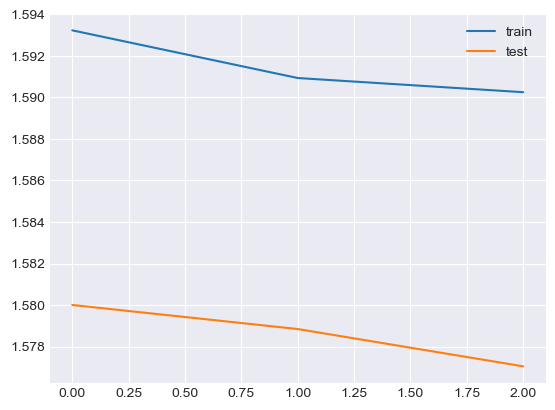

In [54]:


# Assuming your labels are integer encoded, convert them to one-hot
y_train_onehot = to_categorical(y_train, num_classes=5)
y_test_onehot = to_categorical(y_test, num_classes=5)

# number_of_features is the number of features in your input data
number_of_features = X.shape[1]

# Adjust the model for multiclass classification
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_steps, number_of_features)),
    Dropout(0.2),
    LSTM(100, return_sequences=False),
    Dropout(0.2),
    Dense(50, activation='relu'),
    Dense(5, activation='softmax')  # Change for multiclass classification
])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit the model using the one-hot encoded labels
history = model.fit(X_train, y_train_onehot, epochs=3, batch_size=1000,
                    validation_data=(X_test, y_test_onehot),
                    verbose=1, shuffle=False, callbacks=[early_stopping])

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()







In [29]:
results = []
results.append({'acc':123, 'time_steps': 123})
results

[{'acc': 123, 'time_steps': 123}]

In [100]:

# results = []
for tl in np.arange(20,21,1):
     Xs, ys = [], []
     for t in df['symbol'].unique():
          lag = 1
          x = ticker_initialization(t , lag)
          x['input-1'] = minmax(standardize(x['svi']))
          x['input-2'] = minmax(standardize(x['edgar']))
          x['output'] = x[f'shifted-(-{lag})']

          X = x[['input-1', 'input-2']]
          y = x['output']
          time_steps = tl
          
          for i in range(len(X) - time_steps):
               x_array = X.iloc[i:(i + time_steps)].values
               y_array = y.iloc[i + time_steps]
               if not np.isnan(x_array).any():
                         if np.any(x_array == 0).sum() == 0:
                            Xs.append(x_array)
                            ys.append(y_array)

     X_train, X_test, y_train, y_test = train_test_split(np.array(Xs), np.array(ys), test_size=0.20, shuffle=False)

     y_train_onehot = to_categorical(y_train, num_classes=5)
     y_test_onehot = to_categorical(y_test, num_classes=5)

     # number_of_features is the number of features in your input data
     number_of_features = X.shape[1]

     # Adjust the model for multiclass classification
     model = Sequential([
     LSTM(50, return_sequences=True, input_shape=(tl, number_of_features)),
     Dropout(0.2),
     LSTM(100, return_sequences=False),
     Dropout(0.2),
     Dense(50, activation='relu'),
     Dense(5, activation='softmax')  # Change for multiclass classification
     ])
     model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

     early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

     # Fit the model using the one-hot encoded labels
     history = model.fit(X_train, y_train_onehot, epochs=3, batch_size=1000,
                         validation_data=(X_test, y_test_onehot),
                         verbose=1, shuffle=False, callbacks=[early_stopping])
     acc = history.history['val_accuracy'][-1]
     print(acc)
     results.append({'acc':acc, 'time_steps': tl})

Epoch 1/3
123/123 [==============================] - 26s 174ms/step - loss: 1.0441 - accuracy: 0.4479 - val_loss: 0.9629 - val_accuracy: 0.4690
Epoch 2/3
123/123 [==============================] - 19s 155ms/step - loss: 0.9894 - accuracy: 0.4585 - val_loss: 0.9625 - val_accuracy: 0.4690
Epoch 3/3
123/123 [==============================] - 18s 146ms/step - loss: 0.9884 - accuracy: 0.4627 - val_loss: 0.9627 - val_accuracy: 0.4690
0.46899300813674927


In [197]:
# labeling returns
def labeling_2(r):
     if r == 0:
          l = 0
     elif r > 0:
          l = 1
     elif r < 0:
          l = 2
     else:
          l = None
     return l

df['labeled_returns'] = df['returns'].apply(labeling_2)


# results = []
for tl in np.arange(15,16,1):
     Xs, ys = [], []
     for t in df['symbol'].unique():
          lag = 1
          x = ticker_initialization(t , lag)
          x['input-1'] = minmax(standardize(x['svi']))
          x['input-2'] = minmax(standardize(x['edgar']))
          x['output'] = x[f'shifted-(-{lag})']

          X = x[['input-1', 'input-2']]
          y = x['output']
          time_steps = tl
          
          for i in range(len(X) - time_steps):
               x_array = X.iloc[i:(i + time_steps)].values
               y_array = y.iloc[i + time_steps]
               if not np.isnan(x_array).any():
                    if not np.isnan(y_array).any() :
                         if np.any(x_array == 0).sum() == 0:
                            Xs.append(x_array)
                            ys.append(y_array)

     X_train, X_test, y_train, y_test = train_test_split(np.array(Xs), np.array(ys), test_size=0.20, shuffle=False)

     y_train_onehot = to_categorical(y_train, num_classes=5)
     y_test_onehot = to_categorical(y_test, num_classes=5)

     # number_of_features is the number of features in your input data
     number_of_features = X.shape[1]

     # Adjust the model for multiclass classification
     model = Sequential([
     LSTM(50, return_sequences=True, input_shape=(tl, number_of_features)),
     Dropout(0.2),
     LSTM(100, return_sequences=False),
     Dropout(0.2),
     Dense(50, activation='relu'),
     Dense(5, activation='softmax')  # Change for multiclass classification
     ])
     model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

     early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

     # Fit the model using the one-hot encoded labels
     history = model.fit(X_train, y_train_onehot, epochs=3, batch_size=1000,
                         validation_data=(X_test, y_test_onehot),
                         verbose=1, shuffle=False, callbacks=[early_stopping])
     acc = history.history['val_accuracy'][-1]
     print(acc)
     results.append({'acc':acc, 'time_steps': tl, 'new':123})

Epoch 1/3
128/128 [==============================] - 17s 101ms/step - loss: 1.0483 - accuracy: 0.4488 - val_loss: 0.9648 - val_accuracy: 0.4696
Epoch 2/3
128/128 [==============================] - 13s 105ms/step - loss: 0.9902 - accuracy: 0.4578 - val_loss: 0.9638 - val_accuracy: 0.4696
Epoch 3/3
128/128 [==============================] - 13s 104ms/step - loss: 0.9884 - accuracy: 0.4610 - val_loss: 0.9629 - val_accuracy: 0.4696
0.46964797377586365


In [198]:
# labeling returns
def labeling_2(r):
     if r == 0:
          l = 0
     elif r > 0:
          l = 1
     elif r < 0:
          l = 2
     else:
          l = None
     return l

df['labeled_returns'] = df['returns'].apply(labeling_2)


# results = []
for tl in np.arange(16,17,1):
     Xs, ys = [], []
     for t in df['symbol'].unique():
          lag = 1
          x = ticker_initialization(t , lag)
          x['input-1'] = standardize(x['svi'])
          x['input-2'] = standardize(x['edgar'])
          x['output'] = x[f'shifted-(-{lag})']

          X = x[['input-1', 'input-2']]
          y = x['output']
          time_steps = tl
          
          for i in range(len(X) - time_steps):
               x_array = X.iloc[i:(i + time_steps)].values
               y_array = y.iloc[i + time_steps]
               if not np.isnan(x_array).any():
                    if not np.isnan(y_array).any() :
                         Xs.append(x_array)
                         ys.append(y_array)

     X_train, X_test, y_train, y_test = train_test_split(np.array(Xs), np.array(ys), test_size=0.20, shuffle=False)

     y_train_onehot = to_categorical(y_train, num_classes=3)
     y_test_onehot = to_categorical(y_test, num_classes=3)

     # number_of_features is the number of features in your input data
     number_of_features = X.shape[1]

     # Adjust the model for multiclass classification
     model = Sequential([
     LSTM(50, return_sequences=True, input_shape=(tl, number_of_features)),
     Dropout(0.2),
     LSTM(100, return_sequences=False),
     Dropout(0.2),
     Dense(50, activation='relu'),
     Dense(3, activation='softmax')  # Change for multiclass classification
     ])
     model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

     early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

     # Fit the model using the one-hot encoded labels
     history = model.fit(X_train, y_train_onehot, epochs=3, batch_size=1000,
                         validation_data=(X_test, y_test_onehot),
                         verbose=0, shuffle=False, callbacks=[early_stopping])
     acc = history.history['val_accuracy'][-1]
     print(acc)

0.46411240100860596


In [73]:
unique_values, counts = np.unique(y_train, return_counts=True)
print(counts)
print(unique_values)

[124193  94119]
[0. 1.]


In [72]:
print(len(df))
print(len(df.loc[df['svi'] == 0]))
print(len(df.loc[df['edgar'] == 0]))

278980
13977
74961


In [79]:
from sklearn.preprocessing import MinMaxScaler

def minmax(col):
     # Assuming 'your_column' is the column you want to normalize
     scaler = MinMaxScaler()
     # Reshape data for the scaler (it expects 2D array)
     column_reshaped = col.values.reshape(-1, 1)
     # Fit and transform the data
     minmax_col = scaler.fit_transform(column_reshaped)
     return minmax_col


In [83]:
minmax(standardize(df['svi'])).min()

0.0

In [159]:
from keras.layers import Bidirectional, LSTM, Dropout, Dense

In [161]:
# SHORT TERM PREDICTIONS

# labeling returns
def labeling_3(r):
    if -2 <= r <= 2:  
        l = 0
    elif r < -2 or r > 2:
        l = 1
    else:
        l = None
    return l

df_total['labeled_returns'] = df_total['returns'].apply(labeling_3)


for cap in ['high','low']:
    df= df_total.loc[df_total['capitalization'] == 'low']
    for tl in [4]:
        Xs, ys = [], []
        for t in df['symbol'].unique():
            lag = 1
            x = ticker_initialization(t , lag)
            x['input-1'] = minmax(standardize(x['svi']))
            x['input-2'] = minmax(standardize(x['edgar']))
            x['output'] = x[f'shifted-(-{lag})']

            X = x[['input-1', 'input-2']]
            y = x['output']
            time_steps = tl
            
            for i in range(len(X) - time_steps):
                x_array = X.iloc[i:(i + time_steps)].values
                y_array = y.iloc[i + time_steps]
                if not np.isnan(x_array).any():
                        if not np.isnan(y_array).any() :
                            if np.any(x_array == 0).sum() == 0:
                                Xs.append(x_array)
                                ys.append(y_array)

        X_train, X_test, y_train, y_test = train_test_split(np.array(Xs), np.array(ys), test_size=0.20, shuffle=False)

        y_train_onehot = to_categorical(y_train, num_classes=2)
        y_test_onehot = to_categorical(y_test, num_classes=2)

        # number_of_features is the number of features in your input data
        number_of_features = X.shape[1]

        # Adjust the model for multiclass classification
        model = Sequential([
            Bidirectional(LSTM(32, return_sequences=True), input_shape=(tl, number_of_features)),
            Dropout(0.2),
            Bidirectional(LSTM(32)),
            Dense(32, activation='relu'),
            Dense(2, activation='softmax')
        ])
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        # Fit the model using the one-hot encoded labels
        history = model.fit(X_train, y_train_onehot, epochs=50, batch_size=64,
                            validation_data=(X_test, y_test_onehot),
                            verbose=0, shuffle=False, callbacks=[early_stopping])
        acc = history.history['val_accuracy'][-1]
        print(acc)
        # Save the model
        model.save(f'model-{cap}-{tl}.h5')

0.559002161026001
0.5563991069793701


In [163]:
# MID TERM PREDICTIONS

# labeling returns
def labeling_3(r):
    if -2 <= r <= 2:  
        l = 0
    elif r < -2 or r > 2:
        l = 1
    else:
        l = None
    return l

df_total['labeled_returns'] = df_total['returns'].apply(labeling_3)


for cap in ['high','low']:
    df= df_total.loc[df_total['capitalization'] == 'low']
    for tl in [15]:
        Xs, ys = [], []
        for t in df['symbol'].unique():
            lag = 1
            x = ticker_initialization(t , lag)
            x['input-1'] = minmax(standardize(x['svi']))
            x['input-2'] = minmax(standardize(x['edgar']))
            x['output'] = x[f'shifted-(-{lag})']

            X = x[['input-1', 'input-2']]
            y = x['output']
            time_steps = tl
            
            for i in range(len(X) - time_steps):
                x_array = X.iloc[i:(i + time_steps)].values
                y_array = y.iloc[i + time_steps]
                if not np.isnan(x_array).any():
                        if not np.isnan(y_array).any() :
                            if np.any(x_array == 0).sum() == 0:
                                Xs.append(x_array)
                                ys.append(y_array)

        X_train, X_test, y_train, y_test = train_test_split(np.array(Xs), np.array(ys), test_size=0.20, shuffle=False)

        y_train_onehot = to_categorical(y_train, num_classes=2)
        y_test_onehot = to_categorical(y_test, num_classes=2)

        # number_of_features is the number of features in your input data
        number_of_features = X.shape[1]

        # Adjust the model for multiclass classification
        model = Sequential([
            Bidirectional(LSTM(30, return_sequences=True), input_shape=(tl, number_of_features)),
            Dropout(0.2),
            Bidirectional(LSTM(30)),
            Dense(30, activation='relu'),
            Dense(2, activation='softmax')
        ])
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        # Fit the model using the one-hot encoded labels
        history = model.fit(X_train, y_train_onehot, epochs=50, batch_size=60,
                            validation_data=(X_test, y_test_onehot),
                            verbose=0, shuffle=False, callbacks=[early_stopping])
        acc = history.history['val_accuracy'][-1]
        print(acc)
        # Save the model
        model.save(f'model-{cap}-{tl}.h5')

0.5679172277450562
0.565329909324646


In [165]:
# LONG TERM PREDICTIONS

# labeling returns
def labeling_3(r):
    if -2 <= r <= 2:  
        l = 0
    elif r < -2 or r > 2:
        l = 1
    else:
        l = None
    return l

df_total['labeled_returns'] = df_total['returns'].apply(labeling_3)


for cap in ['high','low']:
    df= df_total.loc[df_total['capitalization'] == 'low']
    for tl in [52]:
        Xs, ys = [], []
        for t in df['symbol'].unique():
            lag = 1
            x = ticker_initialization(t , lag)
            x['input-1'] = minmax(standardize(x['svi']))
            x['input-2'] = minmax(standardize(x['edgar']))
            x['output'] = x[f'shifted-(-{lag})']

            X = x[['input-1', 'input-2']]
            y = x['output']
            time_steps = tl
            
            for i in range(len(X) - time_steps):
                x_array = X.iloc[i:(i + time_steps)].values
                y_array = y.iloc[i + time_steps]
                if not np.isnan(x_array).any():
                        if not np.isnan(y_array).any() :
                            if np.any(x_array == 0).sum() == 0:
                                Xs.append(x_array)
                                ys.append(y_array)

        X_train, X_test, y_train, y_test = train_test_split(np.array(Xs), np.array(ys), test_size=0.20, shuffle=False)

        y_train_onehot = to_categorical(y_train, num_classes=2)
        y_test_onehot = to_categorical(y_test, num_classes=2)

        # number_of_features is the number of features in your input data
        number_of_features = X.shape[1]

        # Adjust the model for multiclass classification
        model = Sequential([
            Bidirectional(LSTM(104, return_sequences=True), input_shape=(tl, number_of_features)),
            Dropout(0.2),
            Bidirectional(LSTM(104)),
            Dense(30, activation='relu'),
            Dense(2, activation='softmax')
        ])
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        # Fit the model using the one-hot encoded labels
        history = model.fit(X_train, y_train_onehot, epochs=50, batch_size=30,
                            validation_data=(X_test, y_test_onehot),
                            verbose=0, shuffle=False, callbacks=[early_stopping])
        acc = history.history['val_accuracy'][-1]
        print(acc)
        # Save the model
        model.save(f'model-{cap}-{tl}.h5')

0.5433176755905151
0.5896574854850769


In [166]:
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
# loaded_model = load_model('model-delay-6.h5')
# Generate predictions on the test data
y_pred_onehot = model.predict(X_test)
y_pred = np.argmax(y_pred_onehot, axis=1)  # Convert one-hot predictions to label encoding

# Assuming y_test is already in label encoding form, if not you would also need to apply np.argmax to y_test_onehot
y_true = np.argmax(y_test_onehot, axis=1)

# Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", conf_mat)

# Classification report for precision, recall, f1-score, and accuracy
class_report = classification_report(y_true, y_pred)
print("Classification Report:\n", class_report)

94/94 [==============================] - 4s 26ms/step
Confusion Matrix:
 [[ 262 1098]
 [ 156 1462]]
Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.19      0.29      1360
           1       0.57      0.90      0.70      1618

    accuracy                           0.58      2978
   macro avg       0.60      0.55      0.50      2978
weighted avg       0.60      0.58      0.51      2978



In [170]:
model_names = [
     'model-high-4.h5', 'model-low-4.h5', 
     'model-high-15.h5', 'model-low-15.h5',
     'model-high-52.h5', 'model-low-52.h5'
               ]
for m in model_names:
     model = load_model(m)
     

278980

In [180]:
# model-high-4.h5
time_steps = 4
df_total['labeled_returns'] = df_total['returns'].apply(labeling_3)
df= df_total.loc[df_total['capitalization'] == 'high']
Xs, ys = [], []
for t in df['symbol'].unique():
     lag = 1
     x = ticker_initialization(t , lag)
     x['input-1'] = minmax(standardize(x['svi']))
     x['input-2'] = minmax(standardize(x['edgar']))
     x['output'] = x[f'shifted-(-{lag})']

     X = x[['input-1', 'input-2']]
     y = x['output']
     
     for i in range(len(X) - time_steps):
          x_array = X.iloc[i:(i + time_steps)].values
          y_array = y.iloc[i + time_steps]
          if not np.isnan(x_array).any():
               if not np.isnan(y_array).any() :
                    if np.any(x_array == 0).sum() == 0:
                         Xs.append(x_array)
                         ys.append(y_array)

X_train, X_test, y_train, y_test = train_test_split(np.array(Xs), np.array(ys), test_size=0.20, shuffle=False)

model = load_model('model-high-4.h5')

y_pred_onehot = model.predict(X_test)
y_pred = np.argmax(y_pred_onehot, axis=1) 
y_true = y_test
conf_mat = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", conf_mat)
class_report = classification_report(y_true, y_pred)
print("Classification Report:\n", class_report)

967/967 [==============================] - 4s 3ms/step
Confusion Matrix:
 [[ 4129 12658]
 [ 2594 11546]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.61      0.25      0.35     16787
         1.0       0.48      0.82      0.60     14140

    accuracy                           0.51     30927
   macro avg       0.55      0.53      0.48     30927
weighted avg       0.55      0.51      0.47     30927



In [182]:
# model-low-4.h5
time_steps = 4
df_total['labeled_returns'] = df_total['returns'].apply(labeling_3)
df= df_total.loc[df_total['capitalization'] == 'low']
Xs, ys = [], []
for t in df['symbol'].unique():
     lag = 1
     x = ticker_initialization(t , lag)
     x['input-1'] = minmax(standardize(x['svi']))
     x['input-2'] = minmax(standardize(x['edgar']))
     x['output'] = x[f'shifted-(-{lag})']

     X = x[['input-1', 'input-2']]
     y = x['output']
     
     for i in range(len(X) - time_steps):
          x_array = X.iloc[i:(i + time_steps)].values
          y_array = y.iloc[i + time_steps]
          if not np.isnan(x_array).any():
               if not np.isnan(y_array).any() :
                    if np.any(x_array == 0).sum() == 0:
                         Xs.append(x_array)
                         ys.append(y_array)

X_train, X_test, y_train, y_test = train_test_split(np.array(Xs), np.array(ys), test_size=0.20, shuffle=False)

model = load_model('model-low-4.h5')

y_pred_onehot = model.predict(X_test)
y_pred = np.argmax(y_pred_onehot, axis=1) 
y_true = y_test
print('model-low-4.h5 Results')
class_report = classification_report(y_true, y_pred)
print("Classification Report:\n", class_report)

145/145 [==============================] - 2s 3ms/step
model-low-4.h5 Results
Classification Report:
               precision    recall  f1-score   support

         0.0       0.60      0.13      0.21      2134
         1.0       0.55      0.93      0.69      2476

    accuracy                           0.56      4610
   macro avg       0.58      0.53      0.45      4610
weighted avg       0.58      0.56      0.47      4610



In [183]:
# model-high-15.h5
time_steps = 15
df_total['labeled_returns'] = df_total['returns'].apply(labeling_3)
df= df_total.loc[df_total['capitalization'] == 'high']
Xs, ys = [], []
for t in df['symbol'].unique():
     lag = 1
     x = ticker_initialization(t , lag)
     x['input-1'] = minmax(standardize(x['svi']))
     x['input-2'] = minmax(standardize(x['edgar']))
     x['output'] = x[f'shifted-(-{lag})']

     X = x[['input-1', 'input-2']]
     y = x['output']
     
     for i in range(len(X) - time_steps):
          x_array = X.iloc[i:(i + time_steps)].values
          y_array = y.iloc[i + time_steps]
          if not np.isnan(x_array).any():
               if not np.isnan(y_array).any() :
                    if np.any(x_array == 0).sum() == 0:
                         Xs.append(x_array)
                         ys.append(y_array)

X_train, X_test, y_train, y_test = train_test_split(np.array(Xs), np.array(ys), test_size=0.20, shuffle=False)

model = load_model('model-high-15.h5')

y_pred_onehot = model.predict(X_test)
y_pred = np.argmax(y_pred_onehot, axis=1) 
y_true = y_test
print('model-high-15.h5 Results')
class_report = classification_report(y_true, y_pred)
print("Classification Report:\n", class_report)

875/875 [==============================] - 6s 5ms/step
model-high-15.h5 Results
Classification Report:
               precision    recall  f1-score   support

         0.0       0.62      0.27      0.38     15071
         1.0       0.49      0.80      0.61     12908

    accuracy                           0.52     27979
   macro avg       0.55      0.54      0.49     27979
weighted avg       0.56      0.52      0.48     27979



In [184]:
# model-low-15.h5
time_steps = 15
df_total['labeled_returns'] = df_total['returns'].apply(labeling_3)
df= df_total.loc[df_total['capitalization'] == 'low']
Xs, ys = [], []
for t in df['symbol'].unique():
     lag = 1
     x = ticker_initialization(t , lag)
     x['input-1'] = minmax(standardize(x['svi']))
     x['input-2'] = minmax(standardize(x['edgar']))
     x['output'] = x[f'shifted-(-{lag})']

     X = x[['input-1', 'input-2']]
     y = x['output']
     
     for i in range(len(X) - time_steps):
          x_array = X.iloc[i:(i + time_steps)].values
          y_array = y.iloc[i + time_steps]
          if not np.isnan(x_array).any():
               if not np.isnan(y_array).any() :
                    if np.any(x_array == 0).sum() == 0:
                         Xs.append(x_array)
                         ys.append(y_array)

X_train, X_test, y_train, y_test = train_test_split(np.array(Xs), np.array(ys), test_size=0.20, shuffle=False)

model = load_model('model-low-15.h5')

y_pred_onehot = model.predict(X_test)
y_pred = np.argmax(y_pred_onehot, axis=1) 
y_true = y_test
print('model-low-15.h5 Results')
class_report = classification_report(y_true, y_pred)
print("Classification Report:\n", class_report)

121/121 [==============================] - 2s 5ms/step
model-low-15.h5 Results
Classification Report:
               precision    recall  f1-score   support

         0.0       0.57      0.21      0.31      1775
         1.0       0.56      0.87      0.68      2090

    accuracy                           0.57      3865
   macro avg       0.57      0.54      0.49      3865
weighted avg       0.57      0.57      0.51      3865



In [185]:
# model-high-52.h5
time_steps = 52
df_total['labeled_returns'] = df_total['returns'].apply(labeling_3)
df= df_total.loc[df_total['capitalization'] == 'high']
Xs, ys = [], []
for t in df['symbol'].unique():
     lag = 1
     x = ticker_initialization(t , lag)
     x['input-1'] = minmax(standardize(x['svi']))
     x['input-2'] = minmax(standardize(x['edgar']))
     x['output'] = x[f'shifted-(-{lag})']

     X = x[['input-1', 'input-2']]
     y = x['output']
     
     for i in range(len(X) - time_steps):
          x_array = X.iloc[i:(i + time_steps)].values
          y_array = y.iloc[i + time_steps]
          if not np.isnan(x_array).any():
               if not np.isnan(y_array).any() :
                    if np.any(x_array == 0).sum() == 0:
                         Xs.append(x_array)
                         ys.append(y_array)

X_train, X_test, y_train, y_test = train_test_split(np.array(Xs), np.array(ys), test_size=0.20, shuffle=False)

model = load_model('model-high-52.h5')

y_pred_onehot = model.predict(X_test)
y_pred = np.argmax(y_pred_onehot, axis=1) 
y_true = y_test
print('model-high-52.h5 Results')
class_report = classification_report(y_true, y_pred)
print("Classification Report:\n", class_report)

691/691 [==============================] - 19s 26ms/step
model-high-52.h5 Results
Classification Report:
               precision    recall  f1-score   support

         0.0       0.50      0.00      0.00     11742
         1.0       0.47      1.00      0.64     10357

    accuracy                           0.47     22099
   macro avg       0.48      0.50      0.32     22099
weighted avg       0.49      0.47      0.30     22099



In [186]:
# model-low-52.h5
time_steps = 52
df_total['labeled_returns'] = df_total['returns'].apply(labeling_3)
df= df_total.loc[df_total['capitalization'] == 'low']
Xs, ys = [], []
for t in df['symbol'].unique():
     lag = 1
     x = ticker_initialization(t , lag)
     x['input-1'] = minmax(standardize(x['svi']))
     x['input-2'] = minmax(standardize(x['edgar']))
     x['output'] = x[f'shifted-(-{lag})']

     X = x[['input-1', 'input-2']]
     y = x['output']
     
     for i in range(len(X) - time_steps):
          x_array = X.iloc[i:(i + time_steps)].values
          y_array = y.iloc[i + time_steps]
          if not np.isnan(x_array).any():
               if not np.isnan(y_array).any() :
                    if np.any(x_array == 0).sum() == 0:
                         Xs.append(x_array)
                         ys.append(y_array)

X_train, X_test, y_train, y_test = train_test_split(np.array(Xs), np.array(ys), test_size=0.20, shuffle=False)

model = load_model('model-low-52.h5')

y_pred_onehot = model.predict(X_test)
y_pred = np.argmax(y_pred_onehot, axis=1) 
y_true = y_test
print('model-low-52.h5 Results')
class_report = classification_report(y_true, y_pred)
print("Classification Report:\n", class_report)

94/94 [==============================] - 3s 23ms/step
model-low-52.h5 Results
Classification Report:
               precision    recall  f1-score   support

         0.0       0.63      0.19      0.29      1360
         1.0       0.57      0.90      0.70      1618

    accuracy                           0.58      2978
   macro avg       0.60      0.55      0.50      2978
weighted avg       0.60      0.58      0.51      2978



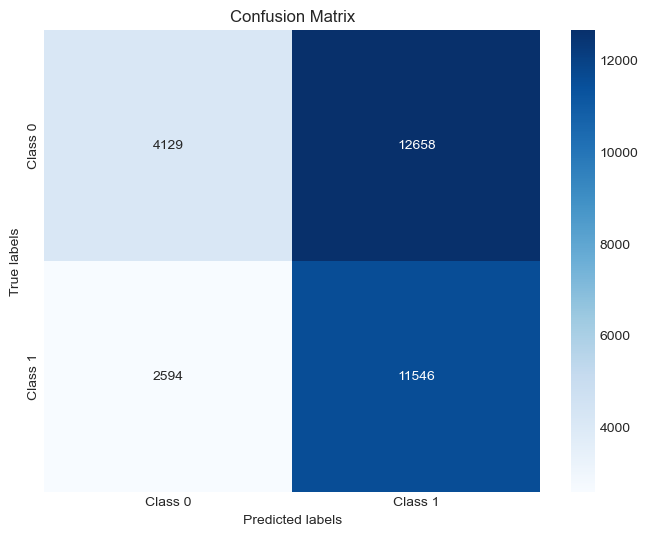

In [181]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred)

# Plotting confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0', 'Class 1'], 
            yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [97]:
# labeling returns
def labeling_4(r):
    if -4 <= r <= 4:  # Simplified range check
        l = 0
    elif r < -4 or r > 4:
        l = 1
    else:
        l = None
    return l

df['labeled_returns'] = df['returns'].apply(labeling_4)


# results = []
for tl in np.arange(20,21,1):
     Xs, ys = [], []
     for t in df['symbol'].unique():
          lag = 1
          x = ticker_initialization(t , lag)
          x['input-1'] = minmax(standardize(x['svi']))
          x['input-2'] = minmax(standardize(x['edgar']))
          x['output'] = x[f'shifted-(-{lag})']

          X = x[['input-1', 'input-2']]
          y = x['output']
          time_steps = tl
          
          for i in range(len(X) - time_steps):
               x_array = X.iloc[i:(i + time_steps)].values
               y_array = y.iloc[i + time_steps]
               if not np.isnan(x_array).any():
                    if not np.isnan(y_array).any() :
                         if np.any(x_array == 0).sum() == 0:
                            Xs.append(x_array)
                            ys.append(y_array)

     X_train, X_test, y_train, y_test = train_test_split(np.array(Xs), np.array(ys), test_size=0.20, shuffle=False)

     y_train_onehot = to_categorical(y_train, num_classes=2)
     y_test_onehot = to_categorical(y_test, num_classes=2)

     # number_of_features is the number of features in your input data
     number_of_features = X.shape[1]

     # Adjust the model for multiclass classification
     model = Sequential([
     LSTM(50, return_sequences=True, input_shape=(tl, number_of_features)),
     Dropout(0.2),
     LSTM(100, return_sequences=False),
     Dropout(0.2),
     Dense(50, activation='relu'),
     Dense(2, activation='softmax')  # Change for multiclass classification
     ])
     model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

     early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

     # Fit the model using the one-hot encoded labels
     history = model.fit(X_train, y_train_onehot, epochs=3, batch_size=1000,
                         validation_data=(X_test, y_test_onehot),
                         verbose=1, shuffle=False, callbacks=[early_stopping])
     acc = history.history['val_accuracy'][-1]
     print(acc)
     results.append({'acc':acc, 'time_steps': tl, 'new':'very extreme'})

Epoch 1/3
123/123 [==============================] - 21s 139ms/step - loss: 0.5413 - accuracy: 0.7793 - val_loss: 0.6128 - val_accuracy: 0.7067
Epoch 2/3
123/123 [==============================] - 16s 132ms/step - loss: 0.5235 - accuracy: 0.7803 - val_loss: 0.6126 - val_accuracy: 0.7067
Epoch 3/3
123/123 [==============================] - 16s 131ms/step - loss: 0.5230 - accuracy: 0.7803 - val_loss: 0.6112 - val_accuracy: 0.7067
0.7066915035247803


In [98]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Generate predictions on the test data
y_pred_onehot = model.predict(X_test)
y_pred = np.argmax(y_pred_onehot, axis=1)  # Convert one-hot predictions to label encoding

# Assuming y_test is already in label encoding form, if not you would also need to apply np.argmax to y_test_onehot
y_true = np.argmax(y_test_onehot, axis=1)

# Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", conf_mat)

# Classification report for precision, recall, f1-score, and accuracy
class_report = classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1'])
print("Classification Report:\n", class_report)

957/957 [==============================] - 8s 8ms/step
Confusion Matrix:
 [[21629     0]
 [ 8977     0]]
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.71      1.00      0.83     21629
     Class 1       0.00      0.00      0.00      8977

    accuracy                           0.71     30606
   macro avg       0.35      0.50      0.41     30606
weighted avg       0.50      0.71      0.59     30606



In [58]:
# labeling returns
def labeling_4(r):
    if -6 <= r <= 6:  # Simplified range check
        l = 0
    elif r < -6 or r > 6:
        l = 1
    else:
        l = None
    return l

df['labeled_returns'] = df['returns'].apply(labeling_4)


# results = []
for tl in np.arange(16,17,1):
     Xs, ys = [], []
     for t in df['symbol'].unique():
          lag = 1
          x = ticker_initialization(t , lag)
          x['input-1'] = standardize(x['svi'])
          x['input-2'] = standardize(x['edgar'])
          x['output'] = x[f'shifted-(-{lag})']

          X = x[['input-1', 'input-2']]
          y = x['output']
          time_steps = tl
          
          for i in range(len(X) - time_steps):
               x_array = X.iloc[i:(i + time_steps)].values
               y_array = y.iloc[i + time_steps]
               if not np.isnan(x_array).any():
                    if not np.isnan(y_array).any() :
                         Xs.append(x_array)
                         ys.append(y_array)

     X_train, X_test, y_train, y_test = train_test_split(np.array(Xs), np.array(ys), test_size=0.20, shuffle=False)

     y_train_onehot = to_categorical(y_train, num_classes=2)
     y_test_onehot = to_categorical(y_test, num_classes=2)

     # number_of_features is the number of features in your input data
     number_of_features = X.shape[1]

     # Adjust the model for multiclass classification
     model = Sequential([
     LSTM(50, return_sequences=True, input_shape=(tl, number_of_features)),
     Dropout(0.2),
     LSTM(100, return_sequences=False),
     Dropout(0.2),
     Dense(50, activation='relu'),
     Dense(2, activation='softmax')  # Change for multiclass classification
     ])
     model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

     early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

     # Fit the model using the one-hot encoded labels
     history = model.fit(X_train, y_train_onehot, epochs=3, batch_size=1000,
                         validation_data=(X_test, y_test_onehot),
                         verbose=1, shuffle=False, callbacks=[early_stopping])
     acc = history.history['val_accuracy'][-1]
     print(acc)
     results.append({'acc':acc, 'time_steps': tl, 'new':'very very extreme'})

Epoch 1/3
220/220 [==============================] - 31s 123ms/step - loss: 0.3470 - accuracy: 0.8965 - val_loss: 0.4444 - val_accuracy: 0.8375
Epoch 2/3
220/220 [==============================] - 26s 119ms/step - loss: 0.3325 - accuracy: 0.8969 - val_loss: 0.4448 - val_accuracy: 0.8375
Epoch 3/3
220/220 [==============================] - 25s 115ms/step - loss: 0.3300 - accuracy: 0.8969 - val_loss: 0.4456 - val_accuracy: 0.8375
0.837511420249939


In [62]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Generate predictions on the test data
y_pred_onehot = model.predict(X_test)
y_pred = np.argmax(y_pred_onehot, axis=1)  # Convert one-hot predictions to label encoding

# Assuming y_test is already in label encoding form, if not you would also need to apply np.argmax to y_test_onehot
y_true = np.argmax(y_test_onehot, axis=1)

# Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", conf_mat)

# Classification report for precision, recall, f1-score, and accuracy
class_report = classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1'])
print("Classification Report:\n", class_report)

1713/1713 [==============================] - 12s 7ms/step
Confusion Matrix:
 [[45904     0]
 [ 8906     0]]
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.84      1.00      0.91     45904
     Class 1       0.00      0.00      0.00      8906

    accuracy                           0.84     54810
   macro avg       0.42      0.50      0.46     54810
weighted avg       0.70      0.84      0.76     54810



In [25]:
df['returns'].std()

311.4485902178977

In [27]:
# labeling returns
def labeling_4(r,e):
    if -e <= r <= e: 
        l = 0
    elif r < -e or r > e:
        l = 1
    else:
        l = None
    return l


for e in [10,15,20,25,20,25,30,35,40,45,50,55,60]:

     df['labeled_returns'] = df['returns'].apply(lambda x: labeling_4(x,e))
     # results = []
     for tl in np.arange(16,17,1):
          Xs, ys = [], []
          for t in df['symbol'].unique():
               lag = 1
               x = ticker_initialization(t , lag)
               x['input-1'] = standardize(x['svi'])
               x['input-2'] = standardize(x['edgar'])
               x['output'] = x[f'shifted-(-{lag})']

               X = x[['input-1', 'input-2']]
               y = x['output']
               time_steps = tl
               
               for i in range(len(X) - time_steps):
                    x_array = X.iloc[i:(i + time_steps)].values
                    y_array = y.iloc[i + time_steps]
                    if not np.isnan(x_array).any():
                         if not np.isnan(y_array).any() :
                              Xs.append(x_array)
                              ys.append(y_array)

          X_train, X_test, y_train, y_test = train_test_split(np.array(Xs), np.array(ys), test_size=0.20, shuffle=False)

          y_train_onehot = to_categorical(y_train, num_classes=2)
          y_test_onehot = to_categorical(y_test, num_classes=2)

          # number_of_features is the number of features in your input data
          number_of_features = X.shape[1]

          # Adjust the model for multiclass classification
          model = Sequential([
          LSTM(50, return_sequences=True, input_shape=(tl, number_of_features)),
          Dropout(0.2),
          LSTM(100, return_sequences=False),
          Dropout(0.2),
          Dense(50, activation='relu'),
          Dense(2, activation='softmax')  # Change for multiclass classification
          ])
          model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

          early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

          # Fit the model using the one-hot encoded labels
          history = model.fit(X_train, y_train_onehot, epochs=1, batch_size=1000,
                              validation_data=(X_test, y_test_onehot),
                              verbose=1, shuffle=False, callbacks=[early_stopping])
          acc = history.history['val_accuracy'][-1]
          print(acc)
          results.append({'acc':acc, 'time_steps': tl, 'new':f'very very extreme {e}'})

242/242 [==============================] - 24s 83ms/step - loss: 0.1771 - accuracy: 0.9607 - val_loss: 0.2576 - val_accuracy: 0.9278
0.9277963042259216
242/242 [==============================] - 25s 86ms/step - loss: 0.0933 - accuracy: 0.9847 - val_loss: 0.1322 - val_accuracy: 0.9701
0.9701443314552307
242/242 [==============================] - 24s 83ms/step - loss: 0.0774 - accuracy: 0.9840 - val_loss: 0.0784 - val_accuracy: 0.9849
0.9848899245262146
242/242 [==============================] - 24s 80ms/step - loss: 0.0481 - accuracy: 0.9961 - val_loss: 0.0532 - val_accuracy: 0.9904
0.9904070496559143
242/242 [==============================] - 24s 81ms/step - loss: 0.0690 - accuracy: 0.9924 - val_loss: 0.0771 - val_accuracy: 0.9849
0.9848899245262146
242/242 [==============================] - 23s 78ms/step - loss: 0.0561 - accuracy: 0.9932 - val_loss: 0.0532 - val_accuracy: 0.9904
0.9904070496559143
242/242 [==============================] - 24s 81ms/step - loss: 0.0433 - accuracy: 0.99

### End of Notebook